In [1]:
import jax
import optax
from jax import numpy as np
from matplotlib import pyplot as plt

In [2]:
from bench.functions import forrester
from utils.plotting import style_axes
from xabo.core.gp import ExactGP
from xabo.core.mean import ZeroMean
from xabo.core.kernel import SquaredExponential

NameError: name 'Parameter' is not defined

In [ ]:
x = np.linspace(0, 1, 7)[:, None]
y = forrester(x)

y_mean = y.mean()
y_std = y.std()

y = (y - y_mean) / y_std

In [ ]:
gp = ExactGP(ZeroMean(), SquaredExponential(0.2, 1.0), 1e-6)
gp.train(x, y)

In [ ]:
x_star = np.linspace(0, 1, 200)[:, None]
y_star_mu, y_star_var = [i.flatten() for i in gp(x_star)]

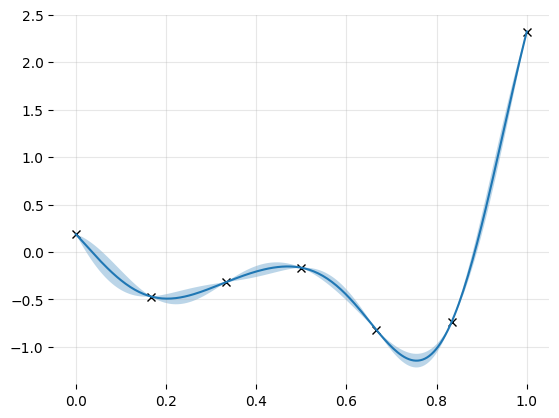

In [ ]:
plt.plot(x, y, "xk")
plt.plot(x_star, y_star_mu)
plt.fill_between(
    x_star.flatten(),
    y_star_mu + 1.96 * np.sqrt(y_star_var),
    y_star_mu - 1.96 * np.sqrt(y_star_var),
    alpha=0.3,
)
style_axes(plt.gca())
plt.show()

In [ ]:
def negative_log_marginal_likelihood(theta: np.ndarray):
    log_ell, log_sigma_v = theta

    ell = np.exp(log_ell)
    sigma_v = np.exp(log_sigma_v)

    gp = ExactGP(ZeroMean(), SquaredExponential(ell, sigma_v), 1e-6)
    gp.train(x, y)

    return -gp.log_marginal_liklihood()

In [ ]:
n_samples = 1_000

In [ ]:
def gen_francesco_thetas(n_samples) -> np.array:
    ell_scale = np.std(x, axis=0).mean() + 1e-6

    log_ls = jax.random.normal(
        key=jax.random.key(42), shape=(n_samples,)
    ) * 0.5 + np.log(ell_scale)
    log_var = (
        jax.random.normal(key=jax.random.key(42), shape=(n_samples,)) * 0.5
        + 0.0
    )

    return np.stack([log_ls, log_var], axis=1)

In [ ]:
def plot_theta(ell, sigma_v):
    gp = ExactGP(ZeroMean(), SquaredExponential(ell, sigma_v), 1e-6)
    gp.train(x, y)
    y_star_mu, y_star_var = [i.flatten() for i in gp(x_star)]
    plt.plot(x, y, "xk")
    plt.plot(x_star, y_star_mu)
    plt.fill_between(
        x_star.flatten(),
        y_star_mu + 1.96 * np.sqrt(y_star_var),
        y_star_mu - 1.96 * np.sqrt(y_star_var),
        alpha=0.3,
    )
    style_axes(plt.gca())
    plt.show()


ℓ - -2.111616611480713, σ_v = -1.0130072832107544, lml - 14.677590370178223


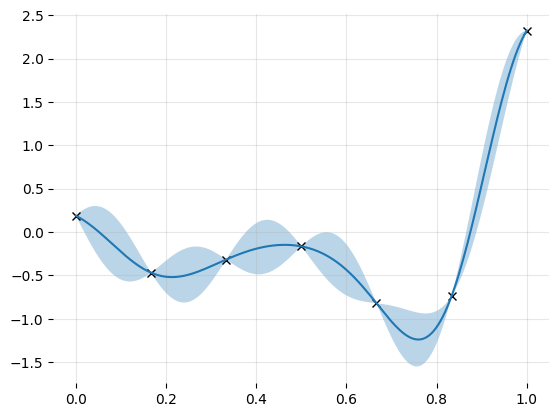

In [ ]:
for gen_func in [gen_francesco_thetas]:
    thetas = gen_func(500)
    nlmls = jax.vmap(negative_log_marginal_likelihood)(thetas)
    nlmls = np.nan_to_num(nlmls, nan=1e10)
    print()
    ell_hat, sigma_v_hat = thetas[np.argmin(nlmls)]
    print(f"ℓ - {ell_hat}, σ_v = {sigma_v_hat}, lml - {np.min(nlmls)}")
    plot_theta(np.exp(ell_hat), np.exp(sigma_v_hat))

In [ ]:
def optimise_adam_single_start(
    theta0,
    n_steps=500,
    learning_rate=2.2e-1,
):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta0)

    value_and_grad = jax.value_and_grad(negative_log_marginal_likelihood)

    def step(carry, _):
        theta, opt_state = carry

        value, grad = value_and_grad(theta)

        updates, opt_state = optimizer.update(grad, opt_state)
        theta = optax.apply_updates(theta, updates)

        return (theta, opt_state), value

    (theta_final, _), values = jax.lax.scan(
        step,
        (theta0, opt_state),
        None,
        length=n_steps,
    )

    return theta_final, values[-1]

In [ ]:
optimise_single_start = jax.jit(optimise_adam_single_start)

In [ ]:
(ell_hat, sigma_v_hat), nlml = optimise_single_start(
    [np.std(x, axis=0).mean() + 1e-6, 0.0]
)
(ell_hat, sigma_v_hat), nlml

((Array(-1.4001027, dtype=float32), Array(-0.5029793, dtype=float32)),
 Array(37.265625, dtype=float32))

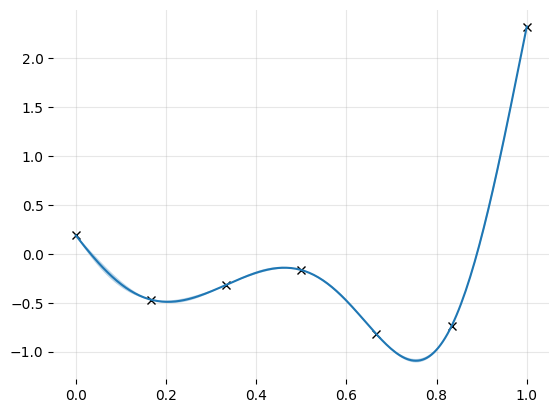

In [ ]:
plot_theta(np.exp(ell_hat), np.exp(sigma_v_hat))